<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Привет! Спасибо, что вовремя сдал задание:) Ты проделал большую работу. Далее в файле мои комментарии ты сможешь найти в ячейках, аналогичных данной ( если рамки комментария зелёные - всё сделано правильно; жёлтые - есть замечания, но не критично; красные - нужно переделать). Не удаляй эти комментарии и постарайся учесть их в ходе выполнения проекта. 

</div>

## Определение перспективного тарифа для телеком компании

Клиентам компании "Мегалайн", федерального оператора сотовой связи, предлагают два тарифных плана: «Смарт» и «Ультра». Нужно проанализировать поведение клиентов по данным 500 пользователей и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

### Шаг 1. Ознакомимся с данными.  
Путь к файлам:
- /datasets/calls.csv
- /datasets/internet.csv
- /datasets/messages.csv
- /datasets/tariffs.csv
- /datasets/users.csv

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


In [4]:
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


In [5]:
print(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


In [6]:
print(tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


In [7]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


В каждой таблице обращают на себя внимание столбцы с датами, где необходимо приведение к нужному типу. Также есть пропущенные значения в столбце `'churn_date'` таблицы `users` (что, впрочем, логично - у большинства пользователей значение пропущено, так как тариф ещё действовал на момент выгрузки данных). 

В дальнейшем будет удобно слить информацию из пяти таблиц в одну общую таблицу, для этого необходимо будет преобразовать таблицы.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Хорошее начало, так держать!)


### Шаг 2. Предобработка данных

Проверим, есть ли в выборке клиенты, перешедшие в наблюдаемые период с одного тарифа на другой:

In [8]:
users.pivot_table(index='user_id', values = 'tariff', 
                  aggfunc = 'count')['tariff'].value_counts()

1    500
Name: tariff, dtype: int64

Таких клиентов не было, то есть каждый клиент пользовался только одним тарифом в течение рассматриваемого периода.

Для объединия данных из таблиц в одну информативную таблицу необходимо подготовить объединяемые таблицы, введя в каждой из таблиц ключи, по которым таблицы будут объединяться. Так как в дальнейшем необходимо будет группировать данные по месяцам, введем новые столбцы с номером месяца, которые извлечем из столбцов с датой.

In [9]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

«Мегалайн» всегда округляет вверх значения минут и мегабайтов, соответственно округлим наши данные:

In [10]:
calls['duration'] = calls['duration'].apply(math.ceil)
internet['mb_used'] = internet['mb_used'].apply(math.ceil)

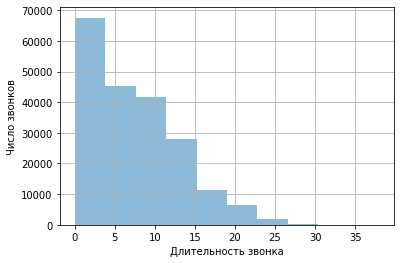

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Длительность звонка')
ax.set_ylabel('Число звонков')
fig = calls['duration'].hist(alpha=0.5)
plt.show()

Видим довольно высокое число звонков с нулевой длительностью. Судя по проведенному исследованию, это звонки без ответа. Такие звонки не участвуют в тарификации и, следовательно, рассматриваться не должны. Удалим их из выборки.

In [12]:
calls = calls[calls['duration'] != 0]

Подумаем, какие еще факторы могут искажать статистику. Рассмотрим, как пользовательская активность распределялась в течение года:

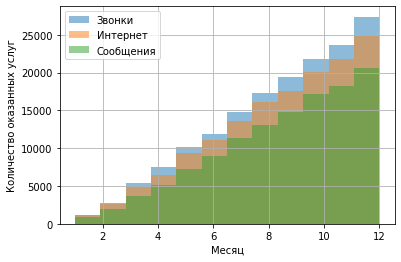

In [13]:
fig, ax = plt.subplots()
ax.set_title('')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество оказанных услуг')
fig = calls['month'].hist(bins=12, alpha=0.5)
fig = internet['month'].hist(bins=12, alpha=0.5)
fig = messages['month'].hist(bins=12, alpha=0.5)
plt.legend(['Звонки', 'Интернет', 'Сообщения'])
plt.show()

<div style="border:solid  red  2px; padding: 20px"> <h1 style="color: red ; margin-bottom:20px">Комментарий наставника</h1>

Подпиши оси на всех графиках

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Хорошо

Видим равномерный рост числа пользователей услуг в течение года. Предположим, что в течение месяца пользователи также присоединялись равномерно, то есть существует группа клиентов, у которых статистика за первый месяц использования тарифа неполная.

Так как в дальнейшем предстоит рассчитывать активность пользователя за месяц и помесячную выручку с каждого пользователя, правильно будет исключить из рассмотрения данные за неполный месяц пользования тарифом, чтобы эти данные не искажали реальную статистику.
Объединим все операции по тарифам в единую таблицу и, построив гистограммы распределения операций по дням месяца и месяцам года, убедимся, что пользователи присоединялись в течение всего месяца и на протяжении всего года.

В дальнейшем информация из сводной таблицы будет полезна для исключения информации по неполным месяцам использования тарифа.

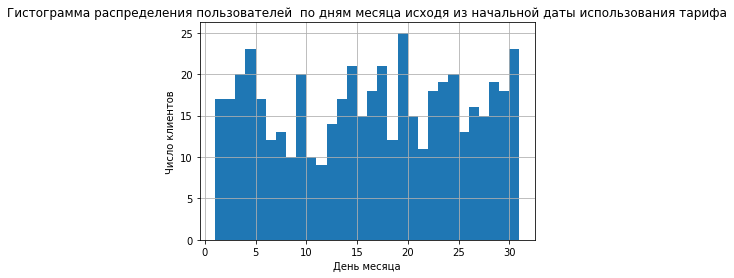

In [14]:
# создадим копии исходных таблиц, в которых переименуем столбцы с датой операции, 
# чтоб в дальнейшем их объединить
calls1 = calls[['user_id', 'call_date']].copy()
calls1.rename(columns={'call_date' : 'transaction_date'}, inplace = True)
internet1 = internet[['user_id', 'session_date']].copy()
internet1.rename(columns={'session_date' : 'transaction_date'}, inplace = True)
messages1 = messages[['user_id', 'message_date']].copy()
messages1.rename(columns={'message_date' : 'transaction_date'}, inplace = True)

all_transactions = pd.concat([calls1, internet1, messages1] , ignore_index=True)

all_transactions['transaction_date'] = pd.to_datetime(all_transactions['transaction_date'])
all_transactions_pivot = all_transactions.pivot_table(values='transaction_date', 
                                                      index='user_id', 
                                                      aggfunc = 'min').reset_index()
# создадим столбец с номером месяца первой транзакции по тарифу
all_transactions_pivot['first_month'] = all_transactions_pivot['transaction_date'].dt.month
#all_transactions_pivot['transaction_date'].dt.day.hist(bins=30)
fig, ax = plt.subplots()
ax.set_title('Гистограмма распределения пользователей  по дням месяца исходя из начальной даты использования тарифа')
ax.set_xlabel('День месяца')
ax.set_ylabel('Число клиентов')
fig = all_transactions_pivot['transaction_date'].dt.day.hist(bins=30)
plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


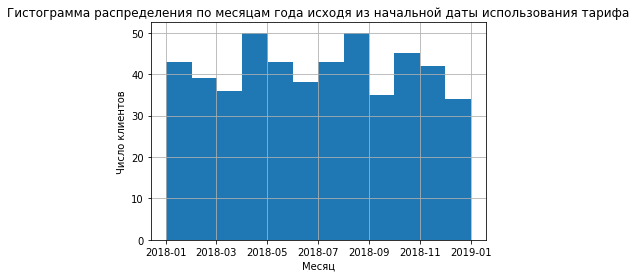

In [15]:
fig, ax = plt.subplots()
ax.set_title('Гистограмма распределения по месяцам года исходя из начальной даты использования тарифа')
ax.set_xlabel('Месяц')
ax.set_ylabel('Число клиентов')
fig = all_transactions_pivot['transaction_date'].hist(bins=12)
plt.show()

Для формирования общей таблицы с данными по месяцам, сведем отдельные таблички по пользователю и месяцу.

In [16]:
calls_pivot = calls.pivot_table(index = ['user_id', 
                                         'month'], 
                                values = 'duration', 
                                aggfunc = ['count', 
                                           'sum'])
calls_pivot.columns = calls_pivot.columns.to_flat_index()
calls_pivot.reset_index(inplace=True)
calls_pivot.rename(columns = {'(user_id, )':'user_id', '(month, )': 'month'}, 
                   inplace = True)

internet_pivot = internet.pivot_table(index = ['user_id', 'month'], 
                                      values = 'mb_used', 
                                      aggfunc = 'sum')
internet_pivot.reset_index(inplace=True)
internet_pivot.rename(columns = {'(user_id, )':'user_id', '(month, )': 'month'}, 
                      inplace = True)

messages_pivot = messages.pivot_table(index = ['user_id', 'month'], 
                                values = 'message_date', 
                                aggfunc = 'count')
messages_pivot.reset_index(inplace=True)


Соединим получившиеся сводные таблицы в единую таблицу, где будет информация об активности каждого пользователя в разбивке по месяцам.

In [17]:
data = internet_pivot.merge(calls_pivot, 
                            how = 'outer', 
                            on = ['user_id', 
                                  'month']).merge(messages_pivot, 
                                                  how = 'outer', 
                                                  on = ['user_id', 
                                                        'month']).merge(users, 
                                                                        how = 'left',
                                                                        on = 'user_id')
data.rename(columns = {'tariff': 'tariff_name'}, inplace=True)
data = data.merge(tariffs, how = 'left', on = 'tariff_name')
data.rename(columns=lambda x: x if type(x) == str else '_'.join(x), inplace=True)
data.rename(columns = {'count_duration': 'calls_count', 
                       'sum_duration': 'calls_duration',
                       'message_date': 'message_count'}, inplace=True)
data

,user_id,month,mb_used,calls_count,calls_duration,message_count,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,2256.0,17.0,159.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,23257.0,28.0,172.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,14016.0,41.0,340.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,14070.0,42.0,408.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,14581.0,46.0,466.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1273,11,NaN,31.0,272.0,29.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3210,1273,12,NaN,38.0,260.0,39.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3211,1377,2,NaN,20.0,179.0,2.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,1000,30720,3000,1950,150,1,1
3212,1392,2,NaN,2.0,13.0,3.0,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra,1000,30720,3000,1950,150,1,1


В получившейся таблице появились пропущенные значения в случае, если какая-то опция не использовалась в какой-то из месяцев (или вообще не использовалась). Заменим пропущенные значения на нули.

In [18]:
data['mb_used'] = data['mb_used'].fillna(0)
data['calls_count'] = data['calls_count'].fillna(0)
data['calls_duration'] = data['calls_duration'].fillna(0)
data['message_count'] = data['message_count'].fillna(0)

Посчитаем помесячную выручку с каждого пользователя, добавим информацию в новый столбец `'Выручка'`:

In [19]:
def revenue(row):
    revenue = 0
    if row['calls_duration'] > row['minutes_included']:
        revenue = (row['calls_duration'] - row['minutes_included'])*row['rub_per_minute']
    if row['mb_used'] > row['mg_per_month_included']:
        revenue = revenue + (row['mb_used'] - row['mg_per_month_included'])/1024*row['rub_per_gb']
    if row['message_count'] > row['messages_included']:
        revenue = revenue + (row['message_count'] - row['messages_included'])*row['rub_per_message']
    revenue = revenue + row['rub_monthly_fee']
    return revenue

data['Выручка'] = data.apply(revenue, axis=1)

Добавим в таблицу информацию о первом (неполном) и последнем (неполном) месяцах использования тарифа.

In [20]:
data = data.merge(all_transactions_pivot[['user_id','first_month']],
                  how = 'outer',on = ['user_id'])
data['last_month'] = pd.DatetimeIndex(data['churn_date']).month

In [21]:
data

,user_id,month,mb_used,calls_count,calls_duration,message_count,age,churn_date,city,first_name,...,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,Выручка,first_month,last_month
0,1000,5,2256.0,17.0,159.0,22.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
1,1000,6,23257.0,28.0,172.0,60.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
2,1000,7,14016.0,41.0,340.0,75.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3,1000,8,14070.0,42.0,408.0,81.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
4,1000,9,14581.0,46.0,466.0,57.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1273,8,0.0,39.0,253.0,41.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3210,1273,9,0.0,28.0,223.0,32.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3211,1273,10,0.0,35.0,315.0,35.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3212,1273,11,0.0,31.0,272.0,29.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN


Используем добавленные столбцы, чтобы исключить из выборки данные за неполный месяц пользования тарифом, чтобы эти данные не искажали реальную статистику. Такими месяцами являются первый и последний (в случае расторжения договора) месяц использования тарифа.

In [22]:
data_new = data[(data['month'] != data['first_month'])&(data['month'] != data['last_month'])]

In [23]:
data_new

,user_id,month,mb_used,calls_count,calls_duration,message_count,age,churn_date,city,first_name,...,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,Выручка,first_month,last_month
1,1000,6,23257.0,28.0,172.0,60.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
2,1000,7,14016.0,41.0,340.0,75.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3,1000,8,14070.0,42.0,408.0,81.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
4,1000,9,14581.0,46.0,466.0,57.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
5,1000,10,14717.0,44.0,350.0,73.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1273,8,0.0,39.0,253.0,41.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3210,1273,9,0.0,28.0,223.0,32.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3211,1273,10,0.0,35.0,315.0,35.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN
3212,1273,11,0.0,31.0,272.0,29.0,46,NaN,Курган,Рэм,...,1000,30720,3000,1950,150,1,1,1950.0,5,NaN


<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Отличная предобработка, всё логично и точно


### Шаг 3. Анализ данных
Опишем поведение клиентов оператора, исходя из выборки. Ответим на следующие вопросы: 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаем среднее количество, дисперсию и стандартное отклонение. 
- Построим гистограммы. Опишем распределения.

Разделим данные по признаку принадлежности к тарифу.

In [24]:
data_new['tariff_name'].value_counts()

smart    1857
ultra     823
Name: tariff_name, dtype: int64

In [25]:
data_smart = data_new[data_new['tariff_name'] == 'smart'].copy()
data_ultra = data_new[data_new['tariff_name'] == 'ultra'].copy()
data_smart.rename(columns = {'calls_duration': 'Суммарная длительность звонков'}, inplace=True)
data_ultra.rename(columns = {'calls_duration': 'Суммарная длительность звонков'}, inplace=True)
data_smart.rename(columns = {'mb_used': 'Суммарный трафик'}, inplace=True)
data_ultra.rename(columns = {'mb_used': 'Суммарный трафик'}, inplace=True)
data_smart.rename(columns = {'message_count': 'Суммарное число сообщений'}, inplace=True)
data_ultra.rename(columns = {'message_count': 'Суммарное число сообщений'}, inplace=True)

Рассчитаем, сколько минут разговора, сообщений и интернет-трафика требуется пользователям каждого тарифа в месяц. Рассчитаем среднее количество, дисперсию и стандартное отклонение этих величин, построим гистограммы.

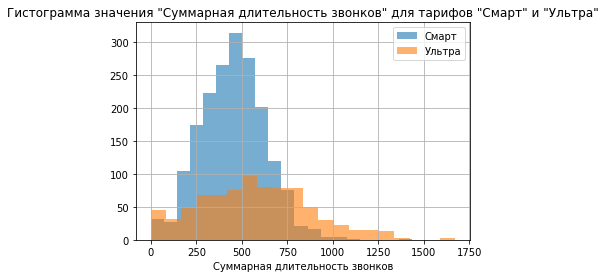

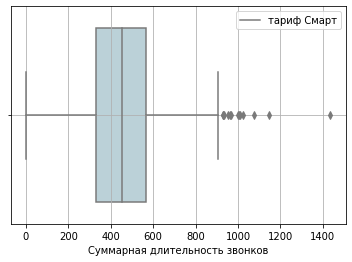

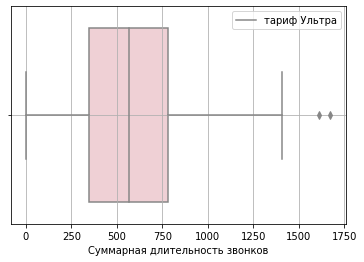

,Среднее,Медиана,Стандартное отклоненение,Дисперсия
Cмарт,453,454,176,"30,976"
Ультра,573,565,307,"94,249"


In [26]:
def tariff_describe(feature):
    smart_mean = round(data_smart[feature].mean())
    smart_median = round(data_smart[feature].median())
    smart_std = round(data_smart[feature].std())
    smart_variance = smart_std**2
    ultra_mean = round(data_ultra[feature].mean())
    ultra_median = round(data_ultra[feature].median())
    ultra_std = round(data_ultra[feature].std())
    ultra_variance = ultra_std**2   
    
    fig, ax = plt.subplots()
    ax.set_title('Гистограмма значения "' + feature + '" для тарифов "Смарт" и "Ультра"')
    ax.set_xlabel(feature)
    ax.set_ylabel('')
    fig = data_smart[feature].hist(alpha=0.6, bins=20).get_figure()
    fig = data_ultra[feature].hist(alpha=0.6, bins=20).get_figure()  
    plt.legend(['Смарт', 'Ультра'])
    plt.show()
    
    
    ax1 = sns.boxplot(x=data_smart[feature], color = 'lightblue', saturation=0.5)
    ax1.grid()
    plt.legend(['тариф Смарт'])
    plt.show()
    ax2 = sns.boxplot(x=data_ultra[feature], color = 'pink', saturation=0.5)
    ax2.grid()
    plt.legend(['тариф Ультра'])
    plt.show()    
        
    dscrb = np.array([[smart_mean, smart_median, smart_std, smart_variance], 
                      [ultra_mean, ultra_median, ultra_std, ultra_variance]])
    metrics = pd.DataFrame(dscrb, index = ['Cмарт', 'Ультра'])
    metrics.columns = ['Среднее', 'Медиана', 'Стандартное отклоненение', 'Дисперсия']
    return metrics.applymap("{0:,.0f}".format)


tariff_describe('Суммарная длительность звонков')

На гистограмме можно видеть, как распределились суммарные (за месяц) длительности звонков пользователей двух тарифов. В среднем пользователи тарифа "Ультра" разговаривают дольше, при этом разброс у них больше - это видно на диаграмме boxplot. Среди пользователей тарифа "Ультра" есть как активные пользователи мобильной связи, так и те, кто эту опцию почти не использует. Среди пользователей тарифа "Смарт" большинство стремится уложиться во включенные в тариф 500 минут разговора в месяц. Всем пользователям тарифа "Ультра" удается уложиться в достаточно большое (3000 минут) количество включенных в тариф минут разговора. 

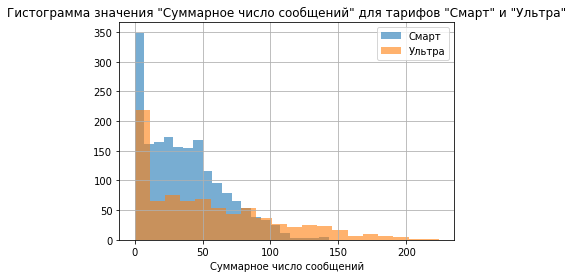

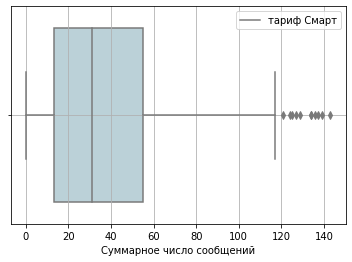

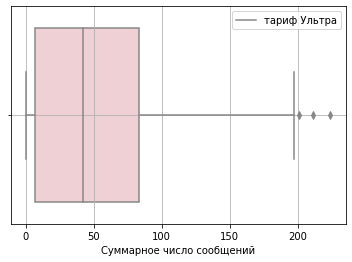

,Среднее,Медиана,Стандартное отклоненение,Дисперсия
Cмарт,36,31,29,841
Ультра,53,42,49,"2,401"


In [27]:
tariff_describe('Суммарное число сообщений')

Также наблюдается тенденция к экономии среди пользователей тарифа "Смарт" - большая часть клиентов не выходит за бесплатный (входящий в тариф) лимит в 50 сообщений, при этом пользователи тарифа "Ультра" с гораздо большим лимитом ненамного чаще отправляют СМС. В обоих тарифах значительная часть пользователей не отправляют сообщений. Как и в случае звонков, в среднем клиенты тарифа "Ультра" более активны. За сообщения сверх включенного лимита (1000) им платить не приходится практически никогда. Также, как и в случае звонков, обращает на себя внимание высокая дисперсия распределения в тарифе "Ультра". 

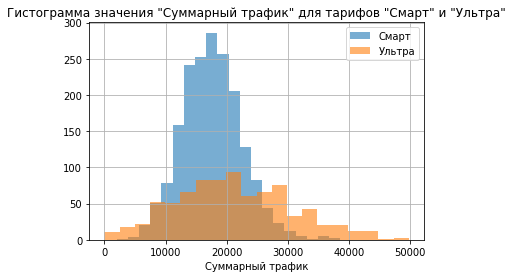

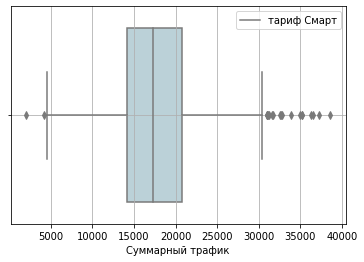

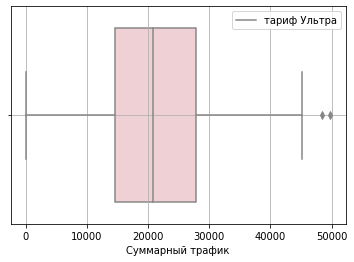

,Среднее,Медиана,Стандартное отклоненение,Дисперсия
Cмарт,"17,573","17,341","4,904","24,049,216"
Ультра,"21,214","20,808","9,478","89,832,484"


In [28]:
tariff_describe('Суммарный трафик')

Что касается интернет трафика, тут пользователям "Смарта" как правило не удается уложиться в бесплатный лимит (15 Гб = 15 360 Мб), в среднем их трафик на 2 Гб выше входящего бесплатного лимита. В среднем пользователь тарифа "Ультра" укладывается в лимит в 30 Гб, но есть часть пользователей, использующих интернет сверх включенного объема трафика и ,соответственно, доплачивающих за это. В среднем пользователи тарифа "Ультра" тратят больше трафика, чем пользователи тарифа "Смарт". При этом дисперсия распределения для них также выше.

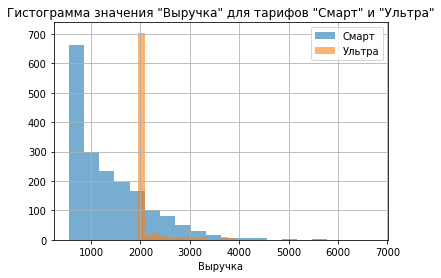

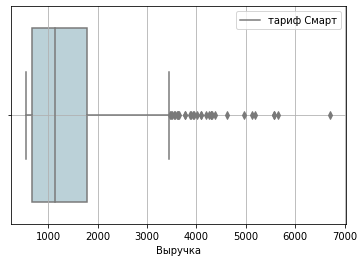

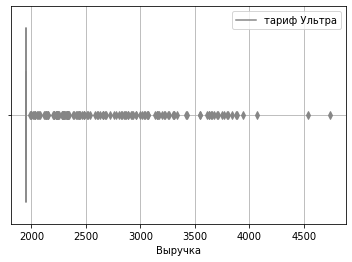

,Среднее,Медиана,Стандартное отклоненение,Дисперсия
Cмарт,"1,343","1,130",803,"644,809"
Ультра,"2,081","1,950",386,"148,996"


In [29]:
tariff_describe('Выручка')


Интересно рассмотреть также, как распределилась ежемесячная выручка пользователей тарифов «Ультра» и «Смарт». Видим, что значительная часть клиентов тарифа "Ультра" укладывается в рамки тарифа, в который включено достаточно большое число минут, сообщений и объем интернет-трафика. При этом, как мы увидели, среди пользователей тарифа "Ультра" есть значительное число пользователей, которые не используют ту или иную опцию. Пользователи "Смарта" чаще всего не укладываются в лимиты по тарифу, и "добирают" платные опции. Для части клиентов это оправдано, так как, в сравнении с клиентами "Ультра", они платят меньше. В среднем на клиенте тарифа "Ультра" компания "Мегалайн" зарабатывает больше. В следующем шаге проверим, статистически значима ли эта разница.

<div style="border:solid  red  2px; padding: 20px"> <h1 style="color: red ; margin-bottom:20px">Комментарий наставника</h1>

Хотелось бы видеть больше визуализаций (например с использованием библиотеки Seaborn)

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Отлично получилось у тебя,класс)

### Шаг 4. Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


Пороговое значение alpha примем за 0.5.

В предыдущем разделе мы уже ознакомились со средней ежемесячной выручкой с клиента каждого из тарифов. Еще раз их выведем:

In [30]:
smart_revenue_mean = data_smart['Выручка'].mean()
ultra_revenue_mean = data_ultra['Выручка'].mean()
print(smart_revenue_mean.round(), ultra_revenue_mean.round())

1343.0 2081.0


Проверим гипотезу о равенстве средней выручки пользователей тарифов "Ультра" и "Смарт"(примем ее за нулевую гипотезу). Альтернативная гипотеза, соотетственно, в том, что эти средние не равны. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.stats.ttest_ind`.

In [31]:
smart_revenue = data_smart['Выручка']
ultra_revenue = data_ultra['Выручка']
alpha = .05
results = st.ttest_ind(
    smart_revenue,
    ultra_revenue)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):   # ваш код: сравните получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу:")
    print("средняя выручка пользователей тарифов 'Ультра' и 'Смарт' отличается статистически значимо")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.495356598013734e-125
Отвергаем нулевую гипотезу:
средняя выручка пользователей тарифов 'Ультра' и 'Смарт' отличается статистически значимо


 ##### Вывод: средняя выручка пользователей тарифов 'Ультра' и 'Смарт' отличается статистически значимо.

Рассмотрим среднюю ежемесячную выручку с пользователей из Москвы и из других регионов:

In [32]:
moscow_revenue_mean = data[data['city'] == 'Москва']['Выручка'].mean()
regions_revenue_mean = data[data['city'] != 'Москва']['Выручка'].mean()
print(moscow_revenue_mean.round(), regions_revenue_mean.round())

1507.0 1482.0


Проверим гипотезу о равенстве средней выручки пользователей из Москвы и пользователей из других регионов(примем ее за нулевую гипотезу). Альтернативная гипотеза, соотетственно, в том, что эти средние не равны. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.stats.ttest_ind`.

In [33]:
moscow_revenue = data[data['city'] == 'Москва']['Выручка']
regions_revenue = data[data['city'] != 'Москва']['Выручка']
alpha = .05
results = st.ttest_ind(
    moscow_revenue,
    regions_revenue)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):   # ваш код: сравните получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу:")
    print("средняя выручка пользователей из Москвы и пользователей из других регионов не равна")
else:
    print("Не получилось отвергнуть нулевую гипотезу:")
    print("средняя выручка пользователей из Москвы и пользователей из других регионов отличается статистически незначимо")

p-значение: 0.47443187631524797
Не получилось отвергнуть нулевую гипотезу:
средняя выручка пользователей из Москвы и пользователей из других регионов отличается статистически незначимо


 ##### Вывод: средняя выручка пользователей из Москвы и пользователей из других регионов отличается статистически незначимо. 

<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Всё верно и точно сделано, как выводы, так и код написаны правильно


## Шаг 5. Общий вывод

Отвечая на вопрос, поставленный коммерческим департаментом, можно заключить, что тариф "Ультра" потенциально более прибыльный продукт, хотя тариф "Смарт" и приносит сейчас больше выручки компании (так как пользователей тарифа "Смарт" больше) - средние месячные траты пользователя тарифа "Ультра" в полтора раза выше, чем у пользователя тарифа "Смарт". 

При этом среди пользователей двух тарифов нет различия в средних ежемесячных тратах на мобильную связь жителей Москвы и регионов - в среднем эта сумма составляет около 1500 рублей. 

Анализ использования опций тарифов показывает:
- в среднем пользователи тарифа "Ультра" разговаривают дольше
- среди пользователей тарифа "Смарт" большинство стремится уложиться в лимит (500 минут в месяц)


- большая часть клиентов тарифа "Смарт" не выходит за лимит в 50 сообщений
- при этом пользователи тарифа "Ультра" с гораздо большим лимитом ненамного чаще отправляют СМС
- в обоих тарифах значительная часть пользователей не отправляют сообщений
- в среднем клиенты тарифа "Ультра" активней отправляют СМС


- пользователям "Смарта" как правило не удается уложиться в бесплатный лимит по трафику(15 Гб = 15 360 Мб), в среднем их трафик на 2 Гб выше входящего бесплатного лимита. 
- в среднем пользователь тарифа "Ультра" укладывается в лимит в 30 Гб, но есть часть пользователей, использующих интернет сверх включенного объема трафика и, соответственно, доплачивающих за это. 
- в среднем пользователи тарифа "Ультра" тратят больше трафика, чем пользователи тарифа "Смарт".

- значительная часть клиентов тарифа "Ультра" укладывается в рамки тарифа
- пользователи "Смарта" чаще всего не укладываются в лимиты по тарифу, и "добирают" платные опции. 
- в среднем на клиенте тарифа "Ультра" компания "Мегалайн" зарабатывает больше.

Можно заключить, что для большей части пользователей тарифа "Смарт" актуальна смена тарифного плана. Маркетологам имеет смысл предложить им альтернативу в виде тарифного плана "Ультра", в случае же, если стоимость тарифа "Ультра" не устроит пользователей тарифа "Смарт", рекомендовано изучить ценовую эластичность спроса на тариф "Ультра". Вероятно, оптимальный вариант для нынешнего пользователя тарифа "Смарт"- новый тариф с ценой, сравнимой со средним ежемесячным платежом (в районе 1500 рублей), с лимитами, больше чем в "Смарт", но меньше, чем в "Ультра"(касается прежде всего трафика). 

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Классные, точные и обоснованные выводы, супер)

<div style="border:solid  green  2px; padding: 20px">

<h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

#### Код

Всё отлично. Из того, что очень порадовало - соблюдена структура проекта, шаги из задания обозначены и выполнены последовательно, код написан аккуратно, используются комментарии к коду, быстро можно понять, какие операции выполняют сложные конструкции. В качестве совета предлагаю глубже изучить библиотеку Seaborn для построения более ярких и качественных визуализаций в Python, так как иногда хорошая красочная визуализация может сказать очень многое о данных.

#### Выводы

Ты пишешь отличные обоснованные выводы по проделанной раблоте и выдвигаешь корректные гипотезы - это очень радует!) Так же видно глубокое понимание проведённого анализа. Было очень интересно проверять твой проект и следить за твоей мыслью, продолжай в том же духе) Удачи!)